# Time Series Analysis Project: Predicting Taxi Ride Orders

## Project Description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to build a model to predict the amount of taxi orders for the next hour. 

As a project accpeptance criteria, the RMSE metric on the test set should not be more than 48.

## Data Overview

Our csv file 'taxi' contains a datetime column and a num_orders field, which represents the number of taxis ordered within the given time period.

## Project Process

1. Import the data and inspect it.
2. Resample the data on an hourly level.
3. Examine the trend, seasonality, and residuals of the data.
4. Determine if the data is stationary or not.
5. Create additional features for the data.
6. Split the data into training, validation, and testing sets.
7. Calculate the RSME of various models including the linear regression, decision tree regressor, random forest regressor, autoregressive, moving average, ARIMA, and prophet models.
8. Determine the best model and get the RSME of the test set.

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tsa.arima.model import ARIMA




#### Read the csv file into a dataframe

In [2]:
#df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0]) # commenting out the path to the file on my local machine
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

# sort the index
df.sort_index(inplace=True)

# get info about the data
print(df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


We have data from March 1, 2018 through August 31, 2018. There are no missing values for our num_orders field. Data types are as expected.

In [3]:
# resample the data to hourly
df = df.resample('1h').sum()

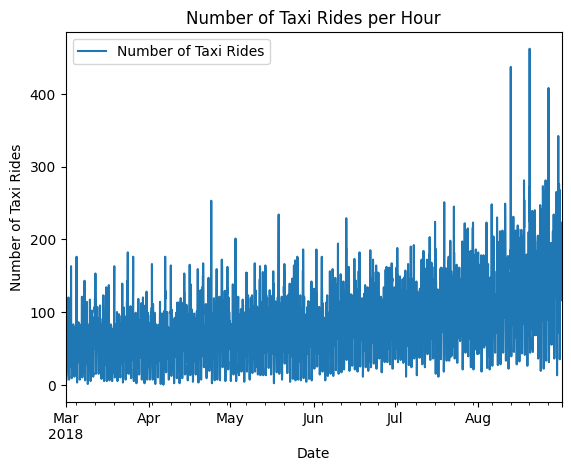

In [4]:
# plot the data
df.plot()
plt.xlabel('Date')
plt.ylabel('Number of Taxi Rides')
plt.title('Number of Taxi Rides per Hour')
plt.legend(['Number of Taxi Rides'])
plt.show()

The timeseries is not stationary since its distribution changes over time. There seems to be an upward trend in the number of hourly taxi rides over time, but we will break the timeseries down into trend, seasonality, and residual components to be sure. We will also run the adfuller test on the training data (once we split the dataset into training and testing sets) to confirm whether it is stationary data or not.

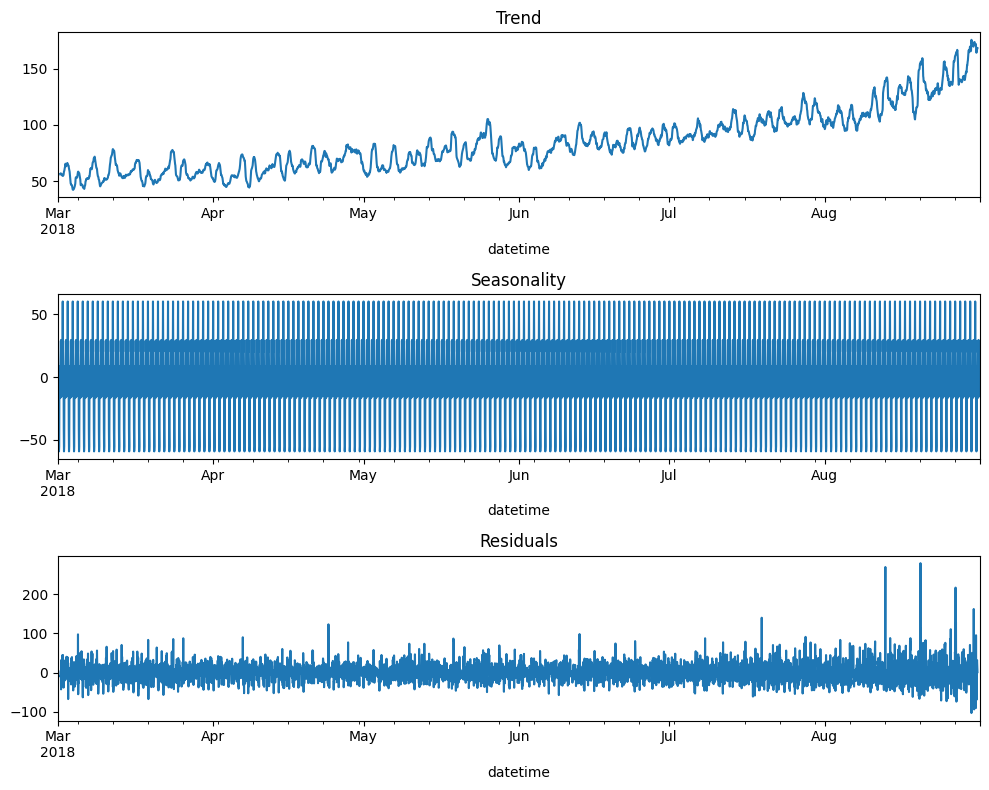

In [5]:
# view the trend, seasonality and residuals of the data
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(10, 8))

# plot the trend, seasonality and residuals of the data
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca()) 
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout() 

There is also an upward, non-linear trend throughout the dataset timeframe with a particular uptick throughout the summer months.

It's hard to judge the seasonality from the noisy graph above. Let's look at the month of March 2018 and the first week of the same month to get a clearer look.

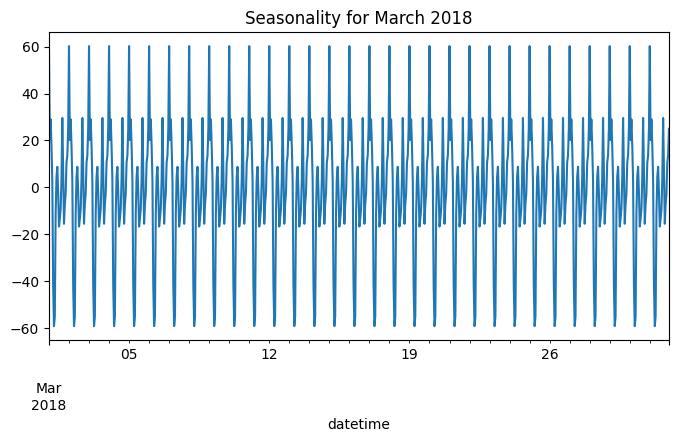

In [6]:
# plot the seasonality for March 2018
plt.figure(figsize=(8, 4))
decomposed.seasonal[0:744].plot()
plt.title('Seasonality for March 2018')
plt.show()


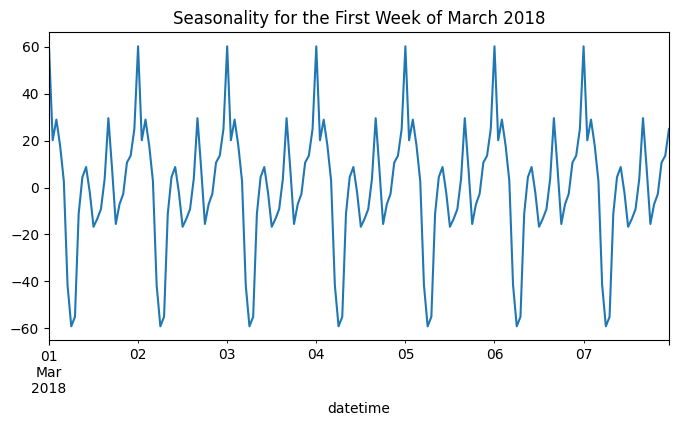

In [7]:
# plot the seasonality for the first week of March 2018
plt.figure(figsize=(8, 4))
decomposed.seasonal[0:168].plot()
plt.title('Seasonality for the First Week of March 2018')
plt.show()

Now we can see that the data has clear seasonality that occurs on a predictable cadence within each day.

In [8]:
# ensure that trend, seasonality and residuals add up to the original data for a slice of the dataset
print('trend + seasonality + residuals:\n', decomposed.trend[100:168] + decomposed.seasonal[100:168] + decomposed.resid[100:168])
print('\n original data: \n',df[100:168])

trend + seasonality + residuals:
 datetime
2018-03-05 04:00:00     34.0
2018-03-05 05:00:00     16.0
2018-03-05 06:00:00      3.0
2018-03-05 07:00:00     14.0
2018-03-05 08:00:00     31.0
                       ...  
2018-03-07 19:00:00     50.0
2018-03-07 20:00:00     76.0
2018-03-07 21:00:00    108.0
2018-03-07 22:00:00    127.0
2018-03-07 23:00:00     94.0
Freq: h, Length: 68, dtype: float64

 original data: 
                      num_orders
datetime                       
2018-03-05 04:00:00          34
2018-03-05 05:00:00          16
2018-03-05 06:00:00           3
2018-03-05 07:00:00          14
2018-03-05 08:00:00          31
...                         ...
2018-03-07 19:00:00          50
2018-03-07 20:00:00          76
2018-03-07 21:00:00         108
2018-03-07 22:00:00         127
2018-03-07 23:00:00          94

[68 rows x 1 columns]


#### Create additional features

In [9]:
# define a function to make features from the data
def make_features(data, max_lag, max_rolling_mean_size):
    data['month'] = data.index.month # get the month
    data['day'] = data.index.day # get the day
    data['dayofweek'] = data.index.dayofweek # get the day of the week

    # create lags from 1 to max_lag
    for lag in range(1, max_lag + 1): 
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # create a rolling mean
    for rolling_mean_size in range(2, max_rolling_mean_size + 1):
        data['rolling_mean_{}'.format(rolling_mean_size)] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean() 
    )

# make a copy of the df to add features to
df_features = df.copy()

# make features from the data using a maximum lag of 20 and a rolling mean window of 7 days
make_features(df_features, 30, 30)

# drop rows with missing values
df_features.dropna(inplace=True)


#### Split the data into training, validation, and test sets


In [10]:
# split the data into train, test and validation sets
train, test = train_test_split(df_features, shuffle=False, test_size=0.1)

# ensure that the train and test data are continuous
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 06:00:00 2018-08-13 16:00:00
2018-08-13 17:00:00 2018-08-31 23:00:00


In [11]:
# create a dataframe to run the adfuller test on
train_df = train['num_orders']

# run the Augmented Dickey-Fuller test to check for stationarity
df_stationarityTest = adfuller(train_df, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  0.0009755816925849859


Though we can't ever be 100% certain, it is highly likely that the time series data is stationary.

#### Create features and target variables for the training and test sets

In [12]:
# create the features for the train, valid, and test data
X_train = train.drop(columns=['num_orders'])
X_test = test.drop(columns=['num_orders'])

# create the target variable for the train, valid, and test data
y_train = train['num_orders']
y_test = test['num_orders']

#### Linear Regression Model

In [13]:
# ititialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# calculate RMSE
rmse = mean_squared_error(y_test, y_pred)**0.5

print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Root Mean Squared Error (RMSE): 46.892


The RMSE of our linear regression model is 46.8, which beats our acceptance score of 48! Let's see if we can improve the score. We'll try the Decision Tree Regressor model next.

#### Decision Tree Regressor Model

In [14]:
# initialize model
model = DecisionTreeRegressor(max_depth=10, random_state=12345) 

# train model on training set
model.fit(X_train, y_train) 

# get model predictions on validation set
y_pred = model.predict(X_test) 

# calculate and print the RMSE
result = mean_squared_error(y_test, y_pred)**0.5 
print(f"RMSE of the best model on the test set: {result}")


RMSE of the best model on the test set: 113.03079887613765


The RMSE for the decision tree regressor is 113.0, which is worse. Let's try a random forest regressor model next.

In [15]:
# initialize model
model = RandomForestRegressor(random_state=12345, n_estimators=500, max_depth=15) 

# train model on training set
model.fit(X_train, y_train) 

# get model predictions on validation set
y_pred = model.predict(X_test) 

# calculate and print the RSME
result = mean_squared_error(y_test, y_pred)**0.5 
print("RMSE of the best model on the test set:", result)


RMSE of the best model on the test set: 42.0009307000303


The RMSE of the random forest regressor model is even better at 42.0! Let's try the XGB Regressor model just to be sure we still can't beat it.

In [16]:
# define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 14],
    'subsample': [0.8, 1.0]
}

# initialize the XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345)

# set up the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=tscv, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

# fit the model using grid search
grid_search.fit(X_train, y_train)

# print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {(-grid_search.best_score_) ** 0.5}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Best RMSE: 25.484847694670854


The best XGboost parameters resulted in a RMSE of 25.4 using cross-validation. This looks promising, but let's get the RSME on the test set to make sure it beats our project's acceptance criteria of 48.

In [17]:
# initialize the XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.8)

# train the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# calculate and print the RMSE
result = mean_squared_error(y_test, y_pred)**0.5
print("RMSE of the best model on the test set:", result)

RMSE of the best model on the test set: 42.938971010607446


The RSME met our project's acceptance standards but did not beat the RSME of our random forest regressor model.

#### Autoregression Model

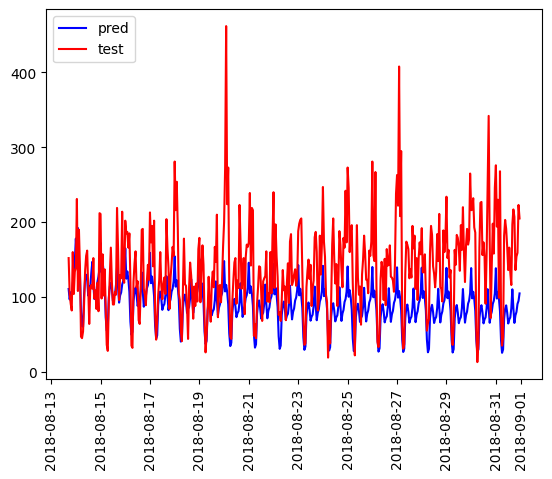

Root Mean Squared Error (RMSE): 69.221


In [18]:
# find optimal number of lags
mod = ar_select_order(endog=train['num_orders'], maxlag=35, seasonal=True)
ar_order = mod.ar_lags

# create AR model and fit it using the training set
ar_model = AutoReg(train['num_orders'], lags=ar_order, seasonal=True)
ar_model = ar_model.fit()

# make predictions
start_value = len(train)
end_value = len(train) + len(test) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

# plot results
plt.plot(ar_pred, color='blue', label='pred')
plt.plot(test['num_orders'], color='red', label='test')
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.show()

# calculate RMSE
rmse = mean_squared_error(test['num_orders'], ar_pred)**0.5
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")


With an RSME of 69.2, the autoregressive model did not perform as well as the random forest regressor model did. Let's move on to a moving average model.

#### Moving Average Model 

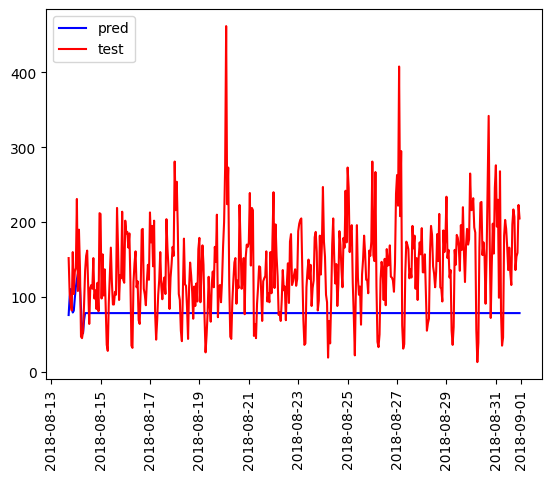

Root Mean Squared Error (RMSE): 84.294


In [23]:
# ignore warning
warnings.filterwarnings('ignore')

# find optimal order for MA model
res = arma_order_select_ic(y=train['num_orders'], max_ar=0, max_ma=16)
ma_order = res.bic_min_order[1]

# create and fit MA model
ma_model = ARIMA(train['num_orders'], order=(0, 0, ma_order))
ma_model = ma_model.fit()

# make predictions
start_value = len(train)
end_value = len(train) + len(test) - 1
ma_pred = ma_model.predict(start=start_value, end=end_value, dynamic=False, seasonal=True)

# plot results
plt.plot(ma_pred, color="blue", label="pred")
plt.plot(test['num_orders'], color="red", label="test")
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.show()

# calculate RMSE
rmse = mean_squared_error(test['num_orders'], ma_pred)**0.5
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")


The moving average model performed worse than most of our prior models with a RSME of 84.2.

# Conclusion

In [24]:
# initialize model
model = RandomForestRegressor(random_state=12345, n_estimators=500, max_depth=15) 

# train model on training set
model.fit(X_train, y_train) 

# get model predictions on validation set
y_pred = model.predict(X_test) 

# get the last datetime hour from the test set
last_datetime_hour = X_test.index[-1]

# create a new dataframe with the features for the next hour
next_hour_features = X_test.loc[last_datetime_hour].copy()
next_hour_features['datetime'] = last_datetime_hour + pd.DateOffset(hours=1)
next_hour_features = next_hour_features.to_frame().T.set_index('datetime')

# use the predict() method of the linear regression model to make the prediction
prediction = model.predict(next_hour_features)

# print the prediction
print("Prediction for the next hour:", prediction)


Prediction for the next hour: [186.39116667]


The random forest regressor model had the best RSME on the test set at a score of 42.1. With this accuracy, Sweet Lift Taxi can be confident in its ability to predict how many taxis will be orderd in the next hour. In fact, the random forest regressor model predicts that ~186 taxis will be ordered in the next hour (the hour that would come after the hour that the original dataset ended with).